In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import loompy
import matplotlib.pyplot as plt
import scipy.optimize
import velocyto as vcy
import glob
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
import pickle
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
%matplotlib inline

/data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
!mkdir data

In [ ]:
from urllib.request import urlretrieve
urlretrieve("http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom", "data/hgForebrainGlut.loom")

In [2]:
import logging
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)

In [ ]:
# Wrap implementation
import rpy2.robjects as robj
from rpy2.robjects.packages import importr

def array_to_rmatrix(X):
    nr, nc = X.shape
    xvec = robj.FloatVector(X.transpose().reshape((X.size)))
    xr = robj.r.matrix(xvec, nrow=nr, ncol=nc)
    return xr

def principal_curve(X, pca=True):
    """
    input : numpy.array
    returns:
    Result::Object
        Methods:
        projections - the matrix of the projectiond
        ixsort - the order ot the points (as in argsort)
        arclength - the lenght of the arc from the beginning to the point
    """
    # convert array to R matrix
    xr = array_to_rmatrix(X)
    
    if pca:
        #perform pca
        t = robj.r.prcomp(xr)
        #determine dimensionality reduction
        usedcomp = max( sum( np.array(t[t.names.index('sdev')]) > 1.1) , 4)
        usedcomp = min([usedcomp, sum( np.array(t[t.names.index('sdev')]) > 0.25), X.shape[0]])
        Xpc = np.array(t[t.names.index('x')])[:,:usedcomp]
        # convert array to R matrix
        xr = array_to_rmatrix(Xpc)

    #import the correct namespace
    princurve = importr("princurve")
    
    #call the function
    fit1 = princurve.principal_curve(xr)
    
    #extract the outputs
    class Results:
        pass
    results = Results()
    results.projections = np.array( fit1[0] )
    results.ixsort = np.array( fit1[1] ) - 1 # R is 1 indexed
    results.arclength = np.array( fit1[2] )
    results.dist = np.array( fit1[3] )
    
    if pca:
        results.PCs = np.array(xr) #only the used components
        
    return results

# Load raw data

In [4]:
vlm = vcy.VelocytoLoom("data/hgForebrainGlut.loom")

In [9]:
# Load an initial clustering (Louvein)
labels = vlm.ca["Clusters"]
manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
vlm.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})

# Load tsne and clusters from pagoda

2018-05-13 13:06:32,115 - DEBUG - findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/data/home/linnarsson/env/miniconda3/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


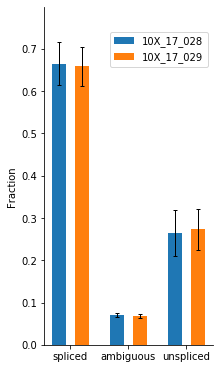

In [10]:
vlm.plot_fractions()

# Velocity Analysis

In [11]:
# just to find the initial cell size
vlm.normalize("S", size=True, log=False)
vlm.normalize("U", size=True,  log=False)

In [12]:
vlm.score_detection_levels(min_expr_counts=30, min_cells_express=20,
                           min_expr_counts_U=0, min_cells_express_U=0)
vlm.filter_genes(by_detection_levels=True)

2018-05-13 13:06:57,427 - DEBUG - Filtering by detection level


2018-05-13 13:07:02,696 - DEBUG - Filtering by cv vs mean


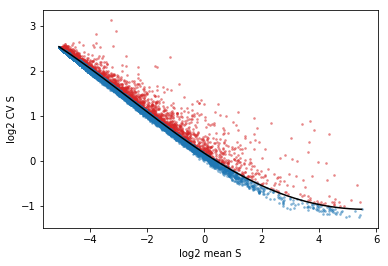

In [13]:
vlm.score_cv_vs_mean(2000, plot=True, max_expr_avg=50, winsorize=True, winsor_perc=(1,99.8), svr_gamma=0.01, min_expr_cells=50)
vlm.filter_genes(by_cv_vs_mean=True)

In [14]:
vlm.score_detection_levels(min_expr_counts=0, min_cells_express=0,
                           min_expr_counts_U=25, min_cells_express_U=20)
vlm.score_cluster_expression(min_avg_U=0.007, min_avg_S=0.06)
vlm.filter_genes(by_detection_levels=True, by_cluster_expression=True)
vlm.normalize_by_total(min_perc_U=0.5)
vlm.adjust_totS_totU(normalize_total=True, fit_with_low_U=False, svr_C=1, svr_gamma=1e-04)

2018-05-13 13:07:14,319 - INFO - Cluster: 0 (187 cells)
2018-05-13 13:07:14,324 - INFO - Cluster: 1 (332 cells)
2018-05-13 13:07:14,331 - INFO - Cluster: 2 (94 cells)
2018-05-13 13:07:14,333 - INFO - Cluster: 3 (249 cells)
2018-05-13 13:07:14,339 - INFO - Cluster: 4 (347 cells)
2018-05-13 13:07:14,346 - INFO - Cluster: 5 (243 cells)
2018-05-13 13:07:14,352 - INFO - Cluster: 6 (268 cells)
2018-05-13 13:07:14,358 - DEBUG - Filtering by cluster expression
2018-05-13 13:07:14,358 - DEBUG - Filtering by detection level


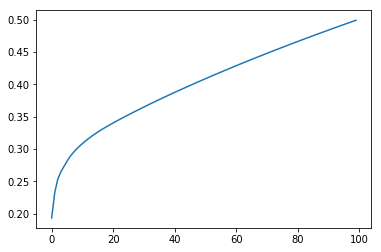

In [16]:
vlm.perform_PCA()
plt.plot(np.cumsum(vlm.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.0055))[0][0]
vlm.pcs[:,1] *= -1 # flip for consistency with previous version

In [17]:
from sklearn.neighbors import NearestNeighbors
import igraph
nn = NearestNeighbors(50)
nn.fit(vlm.pcs[:,:4])
knn_pca = nn.kneighbors_graph(mode='distance')
knn_pca = knn_pca.tocoo()
G = igraph.Graph(list(zip(knn_pca.row, knn_pca.col)), directed=False, edge_attrs={'weight': knn_pca.data})
VxCl = G.community_multilevel(return_levels=False, weights="weight")
labels = np.array(VxCl.membership)

In [21]:
from numpy_groupies import aggregate, aggregate_np

In [22]:
pc_obj = principal_curve(vlm.pcs[:,:4], False)
pc_obj.arclength = np.max(pc_obj.arclength) - pc_obj.arclength
labels = np.argsort(np.argsort(aggregate_np(labels, pc_obj.arclength, func=np.median)))[labels]

In [23]:
manual_annotation = {str(i):[i] for i in labels}
annotation_dict = {v:k for k, values in manual_annotation.items() for v in values }
clusters = np.array([annotation_dict[i] for i in labels])
colors20 = np.vstack((plt.cm.tab20b(np.linspace(0., 1, 20))[::2], plt.cm.tab20c(np.linspace(0, 1, 20))[1::2]))
vlm.set_clusters(clusters, cluster_colors_dict={k:colors20[v[0] % 20,:] for k,v in manual_annotation.items()})

In [24]:
k = 550
vlm.knn_imputation(n_pca_dims=n_comps,k=k, balanced=True,
                   b_sight=np.minimum(k*8, vlm.S.shape[1]-1),
                   b_maxl=np.minimum(k*4, vlm.S.shape[1]-1))


2018-05-13 13:08:38,896 - DEBUG - First search the 1719 nearest neighbours for 1720
2018-05-13 13:08:39,449 - DEBUG - Using the initialization network to find a 550-NN graph with maximum connectivity of 1719
2018-05-13 13:08:39,485 - DEBUG - Returning sparse matrix


In [25]:
vlm.normalize_median()
vlm.fit_gammas(maxmin_perc=[2,95], limit_gamma=True)

In [26]:
vlm.normalize(which="imputed", size=False, log=True)
vlm.Pcs = np.array(vlm.pcs[:,:2], order="C")

In [28]:
vlm.predict_U()
vlm.calculate_velocity()
vlm.calculate_shift()
vlm.extrapolate_cell_at_t(delta_t=1)

In [29]:
vlm.estimate_transition_prob(hidim="Sx_sz", embed="Pcs", transform="log", psc=1,
                             n_neighbors=150, knn_random=True, sampled_fraction=1)

2018-05-13 13:09:25,535 - DEBUG - Calculate KNN in the embedding space
2018-05-13 13:09:26,409 - DEBUG - Correlation Calculation 'knn_random'
2018-05-13 13:09:27,998 - DEBUG - Correlation Calculation for negative control
2018-05-13 13:09:29,359 - WARNING - Nans encountered in corrcoef and corrected to 1s. If not identical cells were present it is probably a small isolated cluster converging after imputation.
2018-05-13 13:09:29,365 - WARNING - Nans encountered in corrcoef_random and corrected to 1s. If not identical cells were present it is probably a small isolated cluster converging after imputation.
2018-05-13 13:09:29,366 - DEBUG - Done Correlation Calculation


In [30]:
vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)

2018-05-13 13:09:34,372 - DEBUG - Calculate transition probability
2018-05-13 13:09:34,395 - DEBUG - Calculate transition probability for negative control


In [31]:
vlm.calculate_grid_arrows(smooth=0.9, steps=(25, 25), n_neighbors=200)

2018-05-13 13:10:03,896 - WARNING - The arrow scale was set to be 'absolute' make sure you know how to properly interpret the plots


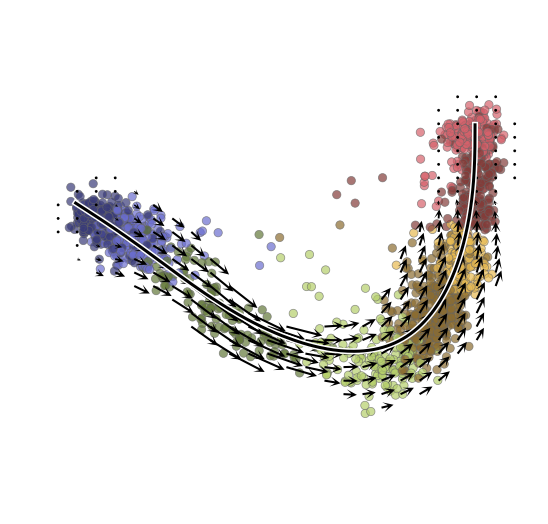

In [33]:
plt.figure(None,(9,9))
vlm.plot_grid_arrows(scatter_kwargs_dict={"alpha":0.7, "lw":0.7, "edgecolor":"0.4", "s":70, "rasterized":True},
                     min_mass=2.9, angles='xy', scale_units='xy',
                     headaxislength=2.75, headlength=5, headwidth=4.8, quiver_scale=0.35, scale_type="absolute")
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="w", lw=6, zorder=1000000)
plt.plot(pc_obj.projections[pc_obj.ixsort,0], pc_obj.projections[pc_obj.ixsort,1], c="k", lw=3, zorder=2000000)
plt.gca().invert_xaxis()
plt.axis("off")
plt.axis("equal");

## Plot level of expression by max proj

In [35]:
ds = loompy.connect("data/hgForebrainGlut.loom")

In [36]:
from matplotlib.colors import LinearSegmentedColormap
def scatter_lev(x, y, score, *args, **kwargs):
    ix_x_sort = np.argsort(score, kind="mergesort")
    ix_yx_sort = ix_x_sort
    args_new = []
    kwargs_new = {}
    for arg in args:
        if type(arg) is np.ndarray:
            args_new.append(arg[ix_x_sort][ix_yx_sort])
        else:
            args_new.append(arg)
    for karg, varg in kwargs.items():
        if type(varg) is np.ndarray:
            kwargs_new[karg] = varg[ix_x_sort][ix_yx_sort]
        else:
            kwargs_new[karg] = varg
    ax = plt.scatter(x[ix_x_sort][ix_yx_sort], y[ix_x_sort][ix_yx_sort], *args_new, **kwargs_new)
    return ax

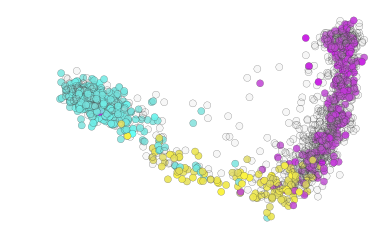

In [37]:
list_genes = np.array(["SOX2", "EOMES", "SLC17A7"])
list_colors = [[104,254,246,255], [251,243,66,255], [203,38,229,255]]
list_colors = np.array([np.array(i)/255 for i in list_colors])

# Extract level of expression
list_xs = []
list_s = []
for gene in list_genes:
    x = ds.layer["spliced"][np.where(ds.row_attrs["Gene"][:] == gene)[0][0], :]
    x = np.mean(vlm.initial_cell_size) * x / vlm.initial_cell_size
    list_s.append(x)
list_s = np.array(list_s)
scal_s = list_s / np.percentile(list_s, 98, 1)[:,None]
max_s = np.argmax(scal_s, 0)

# Make color Array
clarr = np.zeros((max_s.shape[0], 4))
clscore= np.zeros((max_s.shape[0]))
for i in range(len(list_genes)):
    base = (list_colors[i] + np.array([0.6,0.6,0.6, 0.3])) / 2.
    color_gene = LinearSegmentedColormap.from_list(f"color_{list_genes[i]}" , [base, list_colors[i]], )
    sel = (max_s==i) & (scal_s[i] > 0.45)
    clarr[(max_s==i), :] = np.array([0.7,0.7,0.7, 0.1])
    clarr[sel, :] = color_gene(np.log(scal_s[i]+1))[sel]
    clscore[sel] = np.log(scal_s[i]+1)[sel]
    
scatter_lev(-vlm.pcs[:,0], vlm.pcs[:,1], score=clarr[:,-1], c=clarr, s=50, lw=0.2, edgecolor="0.2", rasterized=True)

plt.axis("off");

# Plot different dynamics

Filter genes that peak at the different timepoints removing the ones that show low correlation between velocity and expression

In [38]:
segments = np.linspace(0, np.max(pc_obj.arclength),10)
fragments = -np.ones(pc_obj.arclength.shape, dtype=int)
for i in range(len(segments)-1):
    fragments[(pc_obj.arclength > segments[i]) & (pc_obj.arclength <= segments[i+1])] = i
    
medial_fragments = -np.ones(pc_obj.arclength.shape, dtype=int)
for i in range(len(segments)-2):
    medial_fragments[(pc_obj.arclength > segments[i:i+2].mean()) & (pc_obj.arclength < segments[i+1:i+3].mean())] = i
    
s = aggregate(fragments[fragments>=0], vlm.Sx_sz[:, fragments>=0], func="mean", axis=1)
u = aggregate(fragments[fragments>=0], vlm.Ux_sz[:, fragments>=0], func="mean", axis=1)
v = aggregate(medial_fragments[medial_fragments>=0], vlm.Sx_sz_t[:, medial_fragments>=0] - vlm.Sx_sz[:, medial_fragments>=0], func="mean", axis=1)

In [39]:
# Enrichment score by pseutotime
n_cells = vlm.cluster_ix.shape[0]

# Number of cells per cluster
sizes = np.bincount(vlm.cluster_ix)
# Number of nonzero values per cluster
nnz = aggregate(vlm.cluster_ix, (vlm.Sx_sz>0).astype(float), func="sum", axis=1)
# Mean value per cluster
means = aggregate(vlm.cluster_ix, vlm.Sx_sz, func="mean", axis=1)
# Non-zeros and means over all cells
nnz_overall, means_overall = (vlm.Sx_sz>0).sum(1), vlm.Sx_sz.mean(1)
# Scale by number of cells
f_nnz = nnz / sizes
f_nnz_overall = nnz_overall / n_cells

# Means and fraction non-zero values in other clusters (per cluster)
means_other = ((means_overall * n_cells)[None].T - (means * sizes)) / (n_cells - sizes)
f_nnz_other = ((f_nnz_overall * n_cells)[None].T - (f_nnz * sizes)) / (n_cells - sizes)

enrichment = (f_nnz + 0.1) / (f_nnz_overall[None].T + 0.1) * (means + 0.01) / (means_overall[None].T + 0.01)

In [40]:
#List of top eneriched genes
list_enriched = []
score_enriched = []
for i in range(enrichment.shape[1]):
    score_enriched.append(enrichment[:,i][np.argsort(enrichment[:,i])[::-1]][:350])
    list_enriched.append(vlm.ra["Gene"][np.argsort(enrichment[:,i])[::-1]][:350])

In [41]:
def clean_duplicates(list_enriched, score_enriched):
    for i in range(len(list_enriched)):
        current_ = list_enriched[i]
        for j in range(len(current_)):
            gj = current_[j]
            for n in range(len(list_enriched[i+1:])):
                if gj in list_enriched[n+i+1] and gj != "":
                    if score_enriched[n+i+1][np.where(list_enriched[n+i+1]==gj)[0][0]] > score_enriched[i][j]:
                        list_enriched[i][j] = ""
                    else:
                        list_enriched[n+i+1][np.where(list_enriched[n+i+1]==gj)[0][0]] = ""
    for i in range(enrichment.shape[1]):
        list_enriched[i] = list_enriched[i][list_enriched[i] != ""]
    return list_enriched

def paired_correlations(X, Y):
    Xm = X - X.mean(0)
    Ym = Y - Y.mean(0)
    return (Xm * Ym).sum(0) / (np.linalg.norm(Xm,2,0) * np.linalg.norm(Ym,2,0))

In [42]:
Cc = paired_correlations((s[:,1:] - s[:,:-1]).T, v.T)

In [43]:
for i in range(enrichment.shape[1]):
    selection_bool = np.in1d(list_enriched[i], vlm.ra["Gene"][Cc>0.55])
    score_enriched[i] = score_enriched[i][selection_bool][:120]
    list_enriched[i] = list_enriched[i][selection_bool][:120]

In [44]:
list_enriched = clean_duplicates(list_enriched, score_enriched)

selected_genes_n = int(np.mean([len(list_enriched[i]) for i in range(len(list_enriched))]))
for i in range(enrichment.shape[1]):
    list_enriched[i] = list_enriched[i][:selected_genes_n]
list_enriched_flat = np.hstack(list_enriched)

list_enriched_flat_new = []
for i in list_enriched_flat:
    if i not in list_enriched_flat_new:
        list_enriched_flat_new.append(i)
list_enriched_flat= np.array(list_enriched_flat_new)

In [45]:
s = aggregate(vlm.cluster_ix, vlm.Sx_sz, func="mean", axis=1)
u = aggregate(vlm.cluster_ix, vlm.Ux_sz, func="mean", axis=1)

ix_filter = np.where(np.in1d(vlm.ra["Gene"], list_enriched_flat))[0]
gene_filtered = vlm.ra["Gene"][ix_filter]

Ssort = s[ix_filter,:] / s[ix_filter,:].sum(1)[:,None]
Usort = u[ix_filter,:] / u[ix_filter,:].sum(1)[:,None]
ix1 = np.argsort(Usort.argmax(1), kind='mergesort')
ix2 = np.argsort(Ssort[ix1, :].argmax(1), kind='mergesort')
ixa2b = ix1[ix2]

In [52]:
ra_gene = np.array(vlm.ra["Gene"])[ix_filter][ixa2b]
gammas = np.array(vlm.gammas)[ix_filter][ixa2b]

S = s[ix_filter,:][ixa2b,:]
S_norm = np.array(S) - np.percentile(S, 1,1)[:,None]
S_norm = S_norm / np.percentile(S_norm, 99,1)[:,None]
S_norm = np.clip(S_norm, 0,1)

U = u[ix_filter,:][ixa2b,:]
U_norm = np.array(U) - np.percentile(U, 1,1)[:,None]
U_norm = U_norm / np.percentile(U_norm, 99,1)[:,None]
U_norm = np.clip(U_norm, 0,1)

In [53]:
from matplotlib import colors

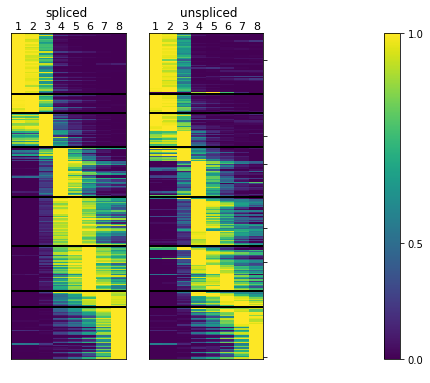

In [57]:
plt.figure(None, (7, 6))
plt.subplot(131)
plt.text(0.3,1.05,"spliced", fontdict={"size":12}, transform=plt.gca().transAxes )
plt.xticks(np.arange(s.shape[1])+0.5, np.arange(s.shape[1])+1, fontsize=11, ha="center", va="center");
plt.gca().tick_params(axis='x', labeltop=True, labelbottom=False, bottom=False )
plt.gca().tick_params(axis='y', labelleft=False, left=False )


plt.pcolormesh(S_norm, cmap=plt.cm.viridis, norm=colors.PowerNorm(gamma=1.5)) # aspect=0.1, interpolation="none"
plt.gca().invert_yaxis()
for hl in np.where(np.diff(Ssort[ixa2b, :].argmax(1)))[0]:
    plt.axhline(hl, c="k", lw=2)
    
plt.subplot(132)
plt.text(0.27,1.05,"unspliced", fontdict={"size":12}, transform=plt.gca().transAxes )
plt.xticks(np.arange(s.shape[1])+0.5, np.arange(s.shape[1])+1, fontsize=11, ha="center", va="center");
plt.gca().tick_params(axis='x', labeltop=True, labelbottom=False, bottom=False )
plt.gca().tick_params(axis='y', labelleft=False, left=False )


cax = plt.pcolormesh(U_norm, cmap=plt.cm.viridis,norm=colors.PowerNorm(gamma=1.5),) #aspect=0.1, interpolation="none",   
plt.gca().invert_yaxis()

for hl in np.where(np.diff(Ssort[ixa2b, :].argmax(1)))[0]:
    plt.axhline(hl, c="k", lw=2)

plt.gca().tick_params(axis='y', labelleft=False, left=False, right=True)
plt.yticks(np.where(np.in1d(ra_gene,["FAM64A", "RNASEH2B", "ELAVL4", "DCX", "STMN2", "GRIA3"]))[0])

plt.subplot(133)
plt.axis("off")
plt.colorbar(cax, ax=plt.gca(),ticks=[0,0.5,1.], orientation='vertical')

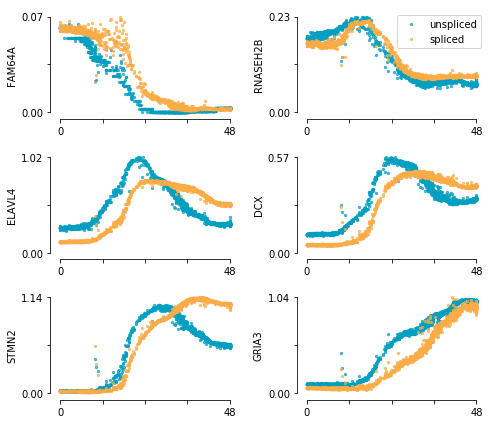

In [58]:
peek_shown = ["FAM64A", "RNASEH2B", "ELAVL4", "DCX", "STMN2", "GRIA3"]
plt.figure(None, (7,6.))
gs = plt.GridSpec(3,2)
for n, gene in enumerate(peek_shown):
    i = np.where(vlm.ra["Gene"] == gene)
    ax = plt.subplot(gs[n])
    plt.scatter(pc_obj.arclength[pc_obj.ixsort], vlm.Ux_sz[i, pc_obj.ixsort],
                alpha=0.7, c=np.array([0,159,193])/255, s=5, label="unspliced")
    plt.scatter(pc_obj.arclength[pc_obj.ixsort], vlm.Sx_sz[i, pc_obj.ixsort]*vlm.gammas[i],
                alpha=0.7, c=np.array([251, 172, 71])/255, s=5, label="spliced")
    m = 0 #np.minimum(np.min(vlm.Ux_sz[i,:]), np.min(vlm.Sx_sz[i,:]*vlm.gammas[i]))
    M = np.maximum(np.max(vlm.Ux_sz[i,:]), np.max(vlm.Sx_sz[i,:]*vlm.gammas[i]))
    plt.ylim(m - 0.07*(M-m), M + 0.07*(M-m))
    plt.ylabel(gene)
    plt.yticks([m,0.5*(m+M),M], [f"{m:.2f}", "", f"{M:.2f}"])
    p = np.min(pc_obj.arclength[pc_obj.ixsort])
    P = np.max(pc_obj.arclength[pc_obj.ixsort])
    plt.xticks(np.linspace(p,P,5), [f"{p:.0f}", "","","", f"{P:.0f}"])
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['left'].set_bounds(m, M)
    ax.spines['bottom'].set_bounds(p, P)
    if n == 1:
        plt.legend()
plt.tight_layout()